In [1]:
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
# import argparse
import os
import pprint
from pickle import dump

Using TensorFlow backend.


In [2]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_sigma = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

In [3]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [4]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [6]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 3

In [7]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [8]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [21]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
____________________________________________________________________________________________

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [10]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

In [11]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [12]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [13]:
models = (encoder, decoder)
data = (x_test, y_test)

reconstruction_loss = mse(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()


Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [14]:
# plot_model(vae,
#             to_file='vae_mlp.png',
#             show_shapes=True)

In [15]:
type(vae)

keras.engine.training.Model

In [16]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
# vae.save_weights('vae_mlp_mnist.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 9s 143us/step - loss: 51.8052 - val_loss: 43.5673
Epoch 2/3
60000/60000 [==============================] - 9s 152us/step - loss: 43.0386 - val_loss: 42.3310
Epoch 3/3
60000/60000 [==============================] - 10s 160us/step - loss: 42.1107 - val_loss: 41.5665


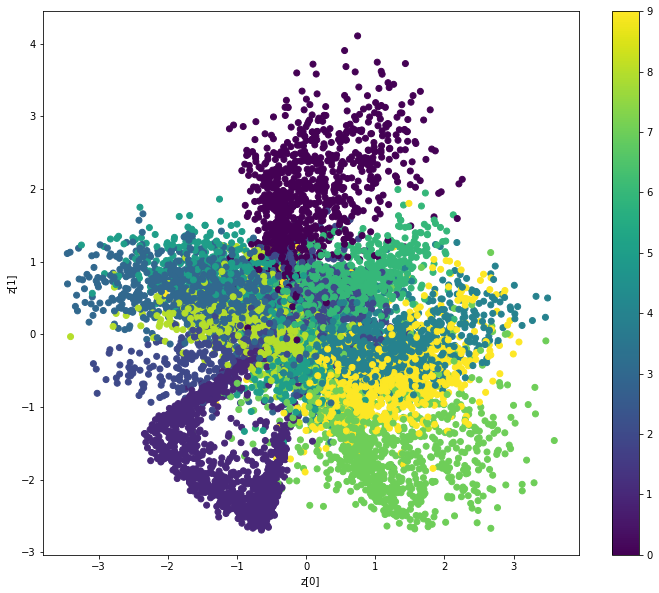

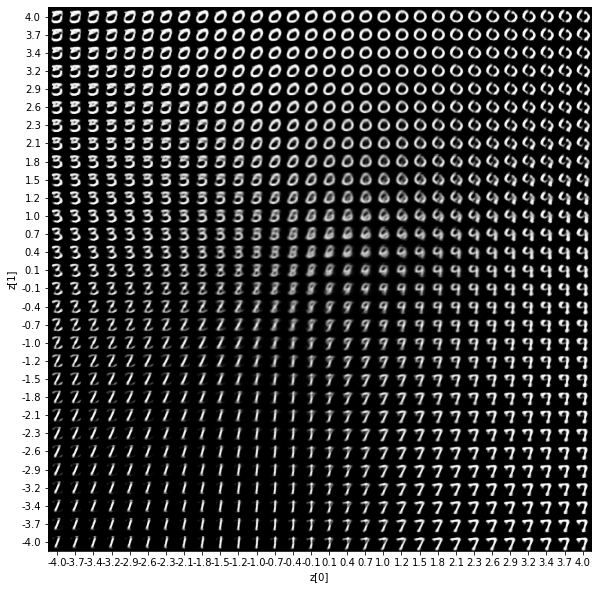

In [17]:
plot_results(models,
                data,
                batch_size=batch_size,
                model_name="vae_mlp")

In [20]:
dump(encoder, open('vae_test.pkl', 'wb'))

# My VAE MLP

## Imports

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
# from tensorflow.keras import objectives
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# import os
import pprint

## Load Data

In [ ]:
songs = pd.read_csv("song_list5.csv")

In [ ]:
x_train = songs[[
    "danceability", "energy", "key", "loudness", "mode", "speechiness", 
    "acousticness", "instrumentalness", "liveness", "valence", "tempo", 
    "duration_ms", "time_signature"]].to_numpy()

In [ ]:
x_train.shape

## Build Model

In [ ]:
batch_size = 32
original_dim = 13
intermediate_dim = 32
latent_dim = 4
epochs = 3

In [ ]:
x = Input(shape=(13,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [ ]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon_std = 1.0
    epsilon = K.random_normal(shape=(latent_dim,),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [ ]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [ ]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [ ]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [ ]:
def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

## Train Model

In [ ]:
# tf.config.experimental_run_functions_eagerly(True)

In [ ]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)#,
        # validation_data=(x_test, x_test))

# Manual Neural Network

In [ ]:
import pandas as pd
import numpy as np
from numpy import random

In [ ]:
songs = pd.read_csv("song_list5.csv")

In [ ]:
x_train = songs[[
    "danceability", "energy", "key", "loudness", "mode", "speechiness", 
    "acousticness", "instrumentalness", "liveness", "valence", "tempo", 
    "duration_ms", "time_signature"]].head(5).to_numpy()

In [ ]:
x_train.shape

In [ ]:
x_train

In [ ]:
# Normalizing the data
x_train = x_train / np.amax(x_train, axis=0)
x_train

In [ ]:
class NeuralNetwork: 
    
    def __init__(self):
        # Setup Arch
        self.inputs = 13
        self.encode1 = 64
        self.encode2 = 32

        self.latent = 4

        self.decode1 = 32
        self.decode2 = 64
        self.outputs = 13
        
        # Initialize Weights
        self.weights1 = np.random.randn(self.inputs, self.encode1)
        self.weights2 = np.random.randn(self.encode1, self.encode2)
        self.weights3a = np.random.randn(self.encode2, self.latent)
        self.weights3b = np.random.randn(self.encode2, self.latent)
        self.weights4 = np.random.randn(self.latent, self.decode1)
        self.weights5 = np.random.randn(self.decode1, self.decode2)
        self.weights6 = np.random.randn(self.decode2, self.outputs)

    def sigmoid(self, X):
        return 1 / (1+np.exp(-X))
    def sigmoidPrime(self, X):
        sX = self.sigmoid(X)
        return sX * (1-sX)

    def relu(self, X):
        return np.maximum(0,X)
    def reluPrime(self, X):
        X[X<=0] = 0
        X[X>0] = 1

    def softmax(self, X):
        expo = np.exp(X)
        expo_sum = np.sum(np.exp(X))
        return expo/expo_sum

    def feed_forward(self, X):
        """
        Calculate the NN inference using feed forward.
        """
        

        self.hidden_sum1 = np.dot(X, self.weights1)
        self.activated_hidden1 = self.relu(self.hidden_sum1)

        self.hidden_sum2 = np.dot(self.activated_hidden1, self.weights2)
        self.activated_hidden2 = self.relu(self.hidden_sum2)

        self.z_log_sigma = np.dot(self.activated_hidden2, self.weights3a)
        self.z_mean = np.dot(self.activated_hidden2, self.weights3b)

        self.z_sample = self.z_mean + np.exp(self.z_log_sigma) * random.normal(loc=0, scale=1, size=(self.latent, ))
        # random.normal(loc=0, scale=1, size=(4, )) # loc is mean | scale is std | size is shape

        self.hidden_sum4 = np.dot(self.z_sample, self.weights4)
        self.activated_hidden4 = self.relu(self.hidden_sum4)

        self.hidden_sum5 = np.dot(self.activated_hidden4, self.weights5)
        self.activated_hidden5 = self.relu(self.hidden_sum5)

        self.hidden_sum6 = np.dot(self.activated_hidden5, self.weights6)

        return self.hidden_sum6

    def backward(self, X,o):
        """
        Back prop thru the network
        """
        self.mean_square_error = ((o-X) ** 2).mean()
        self.reconstruction_loss = self.mean_square_error * self.inputs
        self.kl_loss = (1+self.z_log_sigma-(self.z_mean**2)-np.exp(self.z_log_sigma)) * -0.5
        self.o_error = (reconstruction_loss + kl_loss).mean()

        self.o_delta = self.o_error * self.reluPrime(self.hidden_sum6)


        # self.weights1 += 
        # self.weights2 += 
        # self.weights3a += 
        # self.weights3b += 
        # self.weights4 += 
        # self.weights5 += 
        # self.weights6 += 











        
        # self.o_error = y - o
        
        # # Apply derivative of sigmoid to error
        # self.o_delta = self.o_error * self.sigmoidPrime(self.output_sum)
        
        # # z2 error: how much were our output layer weights off
        # self.z2_error = self.o_delta.dot(self.weights2.T)
        
        # # z2 delta: how much were the weights off?
        # self.z2_delta = self.z2_error*self.sigmoidPrime(self.hidden_sum)

        # self.weights1 += X.T.dot(self.z2_delta) #Adjust first set (input => hidden) weights
        # self.weights2 += self.activated_hidden.T.dot(self.o_delta) #adjust second set (hidden => output) weights

In [ ]:
def reluPrime(X):
    X[X<=0] = 0
    X[X>0] = 1

In [ ]:
nn = NeuralNetwork()
output = nn.feed_forward(x_train[0])
print("intput", x_train[0])
print("output", output)

In [ ]:
mean_square_error = ((output-x_train[0]) ** 2).mean()
reconstruction_loss = mean_square_error * nn.inputs
kl_loss = (1+nn.z_log_sigma-(nn.z_mean**2)-np.exp(nn.z_log_sigma)) * -0.5
o_error = (reconstruction_loss + kl_loss).mean()
o_delta = o_error * nn.hidden_sum6
z2_error = o_delta.dot(nn.weights6.T)
hidden_sum5 = nn.hidden_sum5
# z2_delta = 
z2_error * reluPrime(hidden_sum5)


# o_error * reluPrime(self.output_sum)


In [ ]:
self.z2_delta = self.z2_error*self.sigmoidPrime(self.hidden_sum)

In [ ]:
test_weights1 = np.random.randn(13, 64)
test_weights2 = np.random.randn(64, 32)
test_weights3 = np.random.randn(32, 4)
test_weights4 = np.random.randn(4, 32)
test_weights5 = np.random.randn(32, 64)
test_weights6 = np.random.randn(64, 13)

X1 = np.dot(x_train[0], test_weights1)
X2 = np.maximum(0,X1)
X3 = np.dot(X2, test_weights2)
X4 = np.maximum(0,X3)
X5 = np.dot(X4, test_weights3)
X6 = X5
X7 = np.dot(X6, test_weights4)
X8 = np.maximum(0,X7)
X9 = np.dot(X8, test_weights5)
X10 = np.maximum(0,X9)
X11 = np.dot(X10, test_weights6)
X11

In [ ]:
# Error calculation
mean_square_error = ((output-x_train[0]) ** 2).mean()
reconstruction_loss = mean_square_error * nn.inputs
kl_loss = (1+nn.z_log_sigma-(nn.z_mean**2)-np.exp(nn.z_log_sigma)) * -0.5
vae_loss = (reconstruction_loss + kl_loss).mean()
vae_loss

In [ ]:
# adam optimizer settings
# Good default settings for the tested machine learning problems are alpha=0.001, beta1=0.9, beta2=0.999 and epsilon=10e−8